<h1>Part 1 - Objective, Methodology, End-to-End Demonstration</h1>

<h2>Objective</h2>

Capture the piece placement of an online chess game from a screen capture. Screenshot -> FEN.

A motivation for this project is to facilitate the analysis of chess position by transferring the piece placement into a chess engine. The project will make available "what-if" scenarios for the position an real-time interactive position exploration.

The end-to-end demonstration below will use a screenshot file as an input and output the board state in form of an FEN.

Methodology is described next.

<h2>Methodology + Implementation Classes + Contribution</h2>

My **methodology** to approach the piece placement problem is to divide it into sub-problems that are solved one after another. In this implementation the sub-problems are ordered as follows:<ol>
    <li>Board Detection </li>
    <li>Board Extraction and Splitting into Squares </li>
    <li>Square Classification </li>
    <li>Combination of Squares and Creation of FEN Piece Placement</li> </ol>
    <br>
    
The **implementation** has two main classes and a utility module: <ol>
    <li> Board_Detection(): A labeler, trainer and a detector for creating bounding box proposals for chessboards in a screenshot. Labeler is implemented in gcb_utils using tkinter while trainer and detector are interfaces into PyTorch implementation of Yolov5 (https://github.com/ultralytics/yolov5, see https://pjreddie.com/media/files/papers/yolo.pdf for Yolo.)   
        Main methods are update_labels, train and predict.
    <li> Square_Classification(): A labeler, trainer and a detector for classifying piece content of a square. Labeler is implemented in gcb_utils using tkinter while trainer and detector are simple fully connected neural networks created implemented in Tensorflow.   
        Main methods are update_labels, train and predict.
    <li> gcb_utils: Implements labeling GUIs; chessboard extraction, manipulation and splitting; and FEN piece placement string creation. </ol>
    <br>
Technical **contributions** of the Project: <ol>
    <li> End-to-end neural-network based piece placement generation from a screenshot.
    <li> Transfer learning from an object detection model trained on COCO dataset (yolov5 on PyTorch)
    <li> Bottom up training of a fully connected classifier (Tensorflow)
    <li> Creation of chess-specific and almost platform-independent tkinter-based labeling tools for board labeling and square identification. Tkinter is available on most Unix platforms, macOS and Windows. </ol>
        
        

<br>Now, let's step through the methodology to run through an end-to-end detection path.
      

In [2]:
#import packages
import object_detection
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2>End-to-End Demonstration </h2>
    
    <h2> 1. Board Detection</h2>

<h2>Data Description</h2>

Below is the Data Description from Kaggle <br/>
https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction
<br/>

<h3>Context</h3>

This dataset contains an airline passenger satisfaction survey. What factors are highly correlated to a satisfied (or dissatisfied) passenger? Can you predict passenger satisfaction?
<br/>


<h3>Content</h3>



|Variable | Description |
| :------ | :---------- |
|Gender |Gender of the passengers (Female, Male)|
|Customer |Type The customer type (Loyal customer, disloyal customer)|
|Age|The actual age of the passengers|
|Type of Travel |Purpose of the flight of the passengers (Personal Travel, Business Travel)|
|Class| Travel class in the plane of the passengers (Business, Eco, Eco Plus)|
|Flight distance| The flight distance of this journey|
|Inflight wifi service| Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)|
|Departure/Arrival time convenient| Satisfaction level of Departure/Arrival time convenient|
|Ease of Online booking| Satisfaction level of online booking|
|Gate location| Satisfaction level of Gate location|
|Food and drink| Satisfaction level of Food and drink|
|Online boarding| Satisfaction level of online boarding|
|Seat comfort| Satisfaction level of Seat comfort|
|Inflight entertainment| Satisfaction level of inflight entertainment|
|On-board service| Satisfaction level of On-board service|
|Leg room service| Satisfaction level of Leg room service|
|Baggage handling|Satisfaction level of baggage handling|
|Check-in service| Satisfaction level of Check-in service|
|Inflight service| Satisfaction level of inflight service|
|Cleanliness| Satisfaction level of Cleanliness|
|Departure Delay in Minutes| Minutes delayed when departure|
|Arrival Delay in Minutes| Minutes delayed when Arrival|
|Satisfaction| Airline satisfaction level(Satisfaction, neutral or dissatisfaction)|


<h2>Source</h2>


Dataset modified from the following dataset which itself doesn't lead to an ultimate source: <br/> https://www.kaggle.com/johndddddd/customer-satisfaction



<h2>Exploratory Data Analysis</h2>


<h4>Import Test and Train Data</h4>

In [3]:
train_data = pd.read_csv("data/raw/train.csv")
test_data = pd.read_csv("data/raw/test.csv")
train_data.head()
print(len(train_data),len(test_data), (len(train_data)+len(test_data)))

103904 25976 129880


From what we can see, the data contains both Continuous and Categorical variables. Categorical variables are either ordinal&numerical (survey responses except satisfaction), ordinal&string (satisfaction) or strings (mostly passenger particulars) [Unnamed: 0 and id seem identification related - removed next]

Now, let's explore these variables:

In [4]:
train_data.drop(labels=['Unnamed: 0', 'id'], axis=1,  inplace=True)
test_data.drop(labels=['Unnamed: 0', 'id'], axis=1,  inplace=True)

vars_cont = ['Age', 'Flight Distance', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']

vars_cat_num = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']

vars_cat_str = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

test_data[['Gate location']].value_counts()

Gate location
3                7140
4                6040
2                4837
1                4429
5                3530
dtype: int64

In [5]:
train_data[train_data['Gate location']==1]['satisfaction'].value_counts()

neutral or dissatisfied    8859
satisfied                  8703
Name: satisfaction, dtype: int64

<h4>Explore Continuous Variables</h4>

-Create a brief description of variables for outliers<br/>
-Observe the histogram

                 Age  Flight Distance  Arrival Delay in Minutes  \
count  103904.000000    103904.000000             103594.000000   
mean       39.379706      1189.448375                 15.178678   
std        15.114964       997.147281                 38.698682   
min         7.000000        31.000000                  0.000000   
25%        27.000000       414.000000                  0.000000   
50%        40.000000       843.000000                  0.000000   
75%        51.000000      1743.000000                 13.000000   
max        85.000000      4983.000000               1584.000000   

       Departure Delay in Minutes  
count               103904.000000  
mean                    14.815618  
std                     38.230901  
min                      0.000000  
25%                      0.000000  
50%                      0.000000  
75%                     12.000000  
max                   1592.000000  


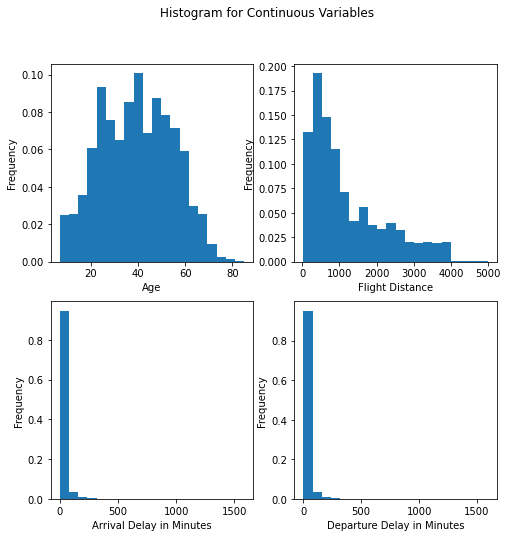

In [6]:
print(train_data[vars_cont].describe())

fig, ax = plt.subplots((len(vars_cont)+1)//2,2)
for _i, _v in enumerate(vars_cont):
    ax[_i//2, _i%2].hist(train_data[_v], weights=np.ones_like(train_data[_v])/train_data[_v].size,  bins=20)
    ax[_i//2, _i%2].set_xlabel(_v)
    ax[_i//2, _i%2].set_ylabel('Frequency')
fig.suptitle('Histogram for Continuous Variables')
fig.set_figwidth(8)
fig.set_figheight(8)

Couple Notes on the above distributions: <br/> 
i)  Departure and Arrival distributions seem to have most of their mass at or around zero, however tend to also have large outliers. We might want to keep this in mind in the future. We could try to come up with a feature that normalizes them. <br/>
ii) Flight distance could indicate generally two types of flights - short distance (<900 miles?) and long-distance (≥900?)

<h4>Explore Categorical Numerical Variables</h4>

-Create a brief description of variables for distribution.<br/>
-Note distribution and extent of zeros (data source indicates, question was either not answered or service was not available)<br/>
-Create a histogram to observe pairwise relationship.



In [ ]:
print('Describe\n{0}\n'.format(train_data[vars_cat_num].describe()))

_cnt_cat_df = pd.DataFrame(index=[0,1,2,3,4,5])
for _ in vars_cat_num:
    a = train_data[_].value_counts()
    _cnt_cat_df[_] = a

    
print('Values Counts:\n{0}\n'.format(_cnt_cat_df)) 
_ = train_data[vars_cat_num] == 0
print('Number of Samples with any O\'s: {0:d} out of {1:d}\n'.format(_.any(axis=1).sum(), len(_)))
del _


_ = sns.pairplot(train_data[vars_cat_num].sample(200), kind='kde')
fig.set_figwidth(20)
fig.set_figheight(20)
for _ax in _.axes.flatten():
    _ax.set_xlabel(_ax.get_xlabel(), rotation = 45, fontsize = 20)
    _ax.set_ylabel(_ax.get_ylabel(), rotation = 0, fontsize = 20)
    _ax.xaxis.get_label().set_horizontalalignment('right')
    _ax.yaxis.get_label().set_horizontalalignment('right')
sns.set_context('poster')


Describe
       Inflight wifi service  Departure/Arrival time convenient  \
count          103904.000000                      103904.000000   
mean                2.729683                           3.060296   
std                 1.327829                           1.525075   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                 5.000000                           5.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count           103904.000000  103904.000000   103904.000000    103904.000000   
mean                 2.756901       2.976883        3.202129         3.250375   
std                  1.398929       1.277621        1.329533         1.349509   
min                  0.000000       0.000000        0.000000   

Couple Notes on the above Distributions: <br/> 
i)   Most distributions look unimodal with a mean above 3 (the mean of uniform excluding 0's.) This may bring up questions as to whether or not there might be enough room to be able to measure improvements in services. <br/>
ii)  Bimodal distributions generally indicate there are two different populations (examples here: Food & Drink, Ease of Online Booking, Leg room service) and could disappear when looked from a different population conditioning (e.g. Class, Age) These in turn can help indicate pockets of demographics where impacts of an improvement could be higher. <br/>
iii) The total number of samples with any zeros (pointing to either non-answered questions or unavailable services) is around 8%. (An analysis could be done to see whether this data was relatively similar to the remaining data)



<h4>Explore Categorical String Variables - i</h4>
-Describe data


In [6]:
df_cat_cnts = train_data[vars_cat_str].value_counts().reset_index().sort_values(by=['satisfaction', 'Class', 'Type of Travel', 'Gender', 'Customer Type'])

df_cat_cnts.rename(columns = {0:'Group Count'}, inplace=True)

print("String Variable Categories ({0:d}) and Count".format(df_cat_cnts.shape[0]))
df_cat_cnts

String Variable Categories (43) and Count


,Gender,Customer Type,Type of Travel,Class,satisfaction,Group Count
5,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied,4449
10,Female,disloyal Customer,Business travel,Business,neutral or dissatisfied,2316
6,Male,Loyal Customer,Business travel,Business,neutral or dissatisfied,4407
13,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied,2120
21,Female,Loyal Customer,Personal Travel,Business,neutral or dissatisfied,938
40,Female,disloyal Customer,Personal Travel,Business,neutral or dissatisfied,7
20,Male,Loyal Customer,Personal Travel,Business,neutral or dissatisfied,944
41,Male,disloyal Customer,Personal Travel,Business,neutral or dissatisfied,4
9,Female,Loyal Customer,Business travel,Eco,neutral or dissatisfied,2497
4,Female,disloyal Customer,Business travel,Eco,neutral or dissatisfied,5042


Couple observations from above: 

1) Each categorical string variable seems to have a small number of categories: 3 for Class and 2 each for the remaining 4. 
2) A closer look at the data shows that there should be 48 separate categorical groups by population categories: 3^1*2^4=48. Yet, there are 43 rows. 

Missing categories are as follows (figured out elsewhere): It might be useful to have this information for analysis in the future. It might also be good to come up with count estimates of missing values to see the extent of missed elements in the sample.

| Gender     |Customer Type   | Type of Travel |  Class         |  satisfaction  | Count Group |
| :----------|:---------------|:---------------|:---------------|:--------------- |-----:|
|Female|disloyal Customer|Personal Travel|Business|satisfied|?|
|Female|disloyal Customer|Personal Travel|Eco Plus|neutral or dissatisfied|?|
|Female|disloyal Customer|Personal Travel|Eco Plus|satisfied|?|
|Male|disloyal Customer|Personal Travel|Business|satisfied|?|
|Male|disloyal Customer|Personal Travel|Eco Plus|satisfied|?|

**Explore Categorical String Variables - ii**<br/>
ii)    Frequency Breakdown<br/>


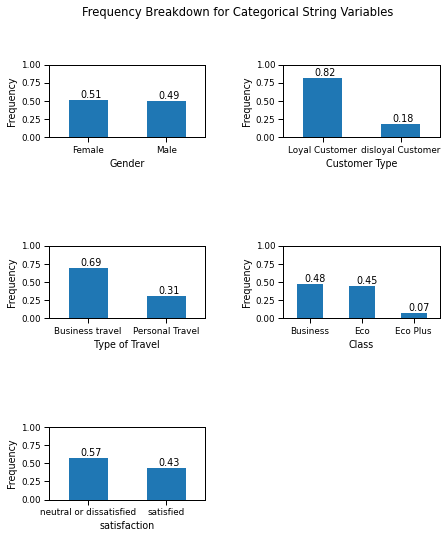

In [12]:

fig, ax = plt.subplots((len(vars_cat_str)+1)//2,2)
for _i, _v in enumerate(vars_cat_str):
    _ax = ax[_i//2, _i%2]
    _train_col = train_data[[_v]].value_counts()/len(train_data.index)
    _train_col.plot(kind='bar', ax = _ax)
    _ax.set_xticklabels(labels=[n[0] for n in _train_col.index], rotation = 0)
    _ax.set_ylim([0,1])
    _ax.set_ylabel('Frequency')
    for idx, val in enumerate(_train_col):
        _ax.text(idx-0.1, val+0.03, '{0:.2f}'.format(val))
ax[-1, -1].axis('off')
    
fig.suptitle('Frequency Breakdown for Categorical String Variables')
fig.subplots_adjust(wspace=0.5, hspace=1.5)
fig.set_figwidth(7)
fig.set_figheight(8)
sns.set_context('paper')

Given the above, we gain an understanding of the relative frequencies of passenger particulars: more 'Loyal Customers' than 'disloyal', more 'Business Travel' than 'Personal', etc. One thing to point out however is the ratio of Business class to Eco class surveytakers. Given the seating in most passenger planes, I would expect the Business/Eco ratio to be much lower. This alone, could indicate a sampling bias in the survey - however there is  have no information regarding the sampling methodology.<br/><br/>

I also understand that the target variable, 'satisfaction' is more similar to a balanced sample, than not. 

Next, we save our data and move to the Data Wrangling portion. <br/>
There we will work on mapping the string data into a more convenient format (numerical) and handle NaN-like values. <br/>
<br/>
Before that, we save the variables for use in the next step.

In [8]:
pd.to_pickle(train_data, 'data/model/train_data.pkl')
pd.to_pickle(test_data, 'data/model/test_data.pkl')